[*********************100%***********************]  44 of 44 completed


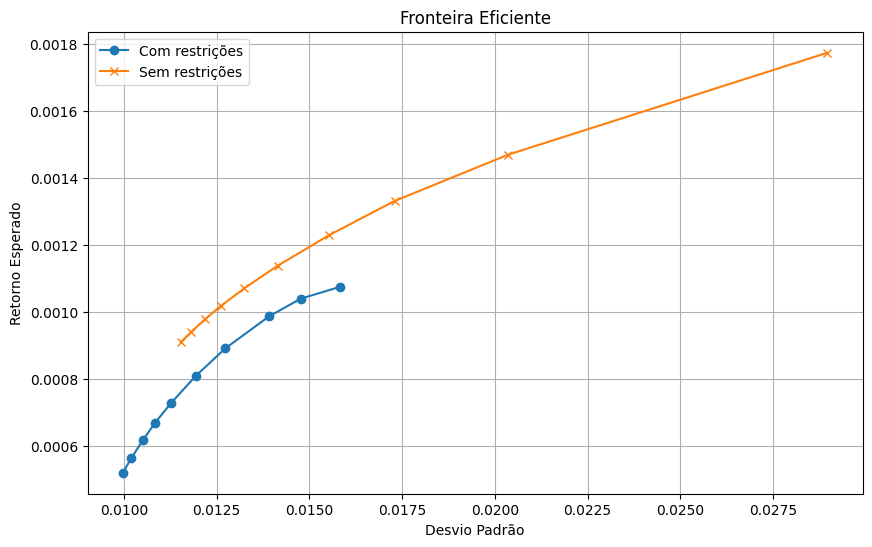

In [13]:
#!pip install yfinance --upgrade --no-cache-dir
#!pip install PyPortfolioOpt

import yfinance as yf
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.pyplot as plt

def otim_cart(acoesIn, dadosIn, restricoesIn, risk_aversions):
  # Calcula os retornos esperados e a matriz de covariância
  mu = dadosIn.mean()
  S = dadosIn.cov()

  # Inicializa listas para armazenar os resultados
  stds_out = []
  returns_out = []
  todos_os_pesos_out = []

  # Loop para cada nível de aversão a risco
  for risk_aversion in risk_aversions:
    # Cria a fronteira eficiente
    ef = EfficientFrontier(mu, S)
    # Adicionar restrições
    for i in range(len(acoesIn)):
      ef.add_constraint(lambda w: w[i] >= restricoesIn['min_weight'])
      ef.add_constraint(lambda w: w[i] <= restricoesIn['max_weight'])
    ef.add_constraint(lambda w: sum(w) == restricoesIn['total_weight'])
    ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] <= restricoesIn['max_weight_subset'])

    # Otimiza a carteira para o nível de aversão a risco atual
    weights = ef.max_quadratic_utility(risk_aversion=risk_aversion)
    cleaned_weights = ef.clean_weights()
    todos_os_pesos_out.append(cleaned_weights) # Armazenar os pesos limpos na lista
    # Obtém o retorno esperado e o desvio padrão da carteira otimizada
    ret = ef.portfolio_performance(verbose=False)[0]
    std = ef.portfolio_performance(verbose=False)[1]
    # Adiciona os resultados às listas
    stds_out.append(std)
    returns_out.append(ret)

  return stds_out, returns_out, todos_os_pesos_out


# Define as ações da B3
acoes = ['VALE3.SA', 'PETR4.SA', 'ITUB4.SA', 'BBDC4.SA', 'B3SA3.SA', 'ABEV3.SA', 'WEGE3.SA', 'ITSA4.SA', 'SUZB3.SA', 'BBAS3.SA', 'LREN3.SA', 'RENT3.SA', 'CSAN3.SA', 'JBSS3.SA', 'EQTL3.SA', 'RADL3.SA', 'GGBR4.SA', 'CMIG4.SA', 'CPFE3.SA', 'BRFS3.SA', 'CCRO3.SA', 'UGPA3.SA', 'HYPE3.SA', 'RAIL3.SA', 'GOAU4.SA', 'MRFG3.SA', 'KLBN11.SA', 'COGN3.SA', 'MULT3.SA', 'EGIE3.SA', 'CSNA3.SA', 'TAEE11.SA', 'VIVT3.SA', 'TIMS3.SA', 'TOTS3.SA', 'SANB11.SA', 'QUAL3.SA', 'FLRY3.SA', 'PCAR3.SA', 'MGLU3.SA', 'HAPV3.SA', 'CRFB3.SA', 'USIM5.SA', 'GOLL4.SA']

# Coleta os dados históricos das ações
dados = yf.download(acoes, start='2021-01-01', end='2023-01-01')['Close']

dadosRet = dados.pct_change()
dadosRet = dadosRet.dropna()
dadosRet.index = pd.to_datetime(dadosRet.index)

# Restrições
restricoes1 = {
    'min_weight': 0.002,  # Alocação mínima de 0,2%
    'max_weight': 0.10,   # Alocação máxima de 10%
    'total_weight': 1.0,   # Soma das alocações igual a 1
    'max_weight_subset': 0.25  # Alocação máxima para VALE3, PETR4, ITUB4, ABEV3
}

# Mantém apenas Restrição de soma dos pesos = 1
restricoes2 = {
    'min_weight': 0.0,
    'max_weight': 1.0,
    'total_weight': 1.0,   # Soma das alocações igual a 1
    'max_weight_subset': 1.0
}

# Define os níveis de aversão a risco
risk_aversions1 = np.linspace(1, 20, 10)
risk_aversions2 = np.linspace(1, 10, 10)

stds1, returns1, todos_os_pesos1 = otim_cart(acoes, dadosRet, restricoes1, risk_aversions1)
stds2, returns2, todos_os_pesos2 = otim_cart(acoes, dadosRet, restricoes2, risk_aversions2)


# Plota a fronteira eficiente
plt.figure(figsize=(10, 6))
plt.plot(stds1, returns1, marker='o', label='Com restrições')
plt.plot(stds2, returns2, marker='x', label = 'Sem restrições')
plt.legend()
plt.xlabel('Desvio Padrão')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira Eficiente')
plt.grid(True)
plt.show()